In [ ]:
import pandas as pd
import seaborn as sns
import string 
import re
import nltk
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
import warnings

warnings.filterwarnings("ignore")
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
msg=pd.read_csv('/content/spam (1).csv',encoding='latin-1')
msg.drop(['Unnamed: 2','Unnamed: 3','Unnamed: 4'],axis=1,inplace=True)
msg.rename(columns={'v1':'label','v2':'text'},inplace=True)
msg.head()

,label,text
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [ ]:
msg.describe()

,label,text
count,5572,5572
unique,2,5169
top,ham,"Sorry, I'll call later"
freq,4825,30


In [ ]:
for i in msg.index:
  if msg['label'][i]=='ham':
    msg['label'][i]=0
  else:
    msg['label'][i]=1
msg.head()

,label,text
0,0,"Go until jurong point, crazy.. Available only ..."
1,0,Ok lar... Joking wif u oni...
2,1,Free entry in 2 a wkly comp to win FA Cup fina...
3,0,U dun say so early hor... U c already then say...
4,0,"Nah I don't think he goes to usf, he lives aro..."


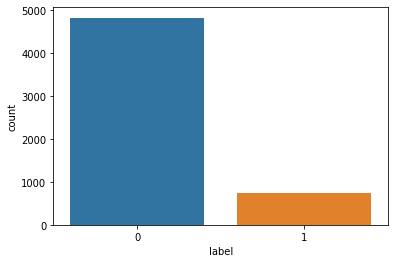

In [ ]:
#category count plot (count of spam and ham)
sns.countplot(msg.label)

In [ ]:
#data description grouped by labels 
msg.groupby('label').describe()

text                                                               
      count unique                                                top freq
label                                                                     
0      4825   4516                             Sorry, I'll call later   30
1       747    653  Please call our customer service representativ...    4

In [ ]:
#dropping duplicate rows
msg=msg.drop_duplicates()
msg.groupby('label').describe()

text                                                               
      count unique                                                top freq
label                                                                     
0      4516   4516  Or better still can you catch her and let ask ...    1
1       653    653  Urgent! Please call 0906346330. Your ABTA comp...    1

In [ ]:
#adding length column to the dataset 
msg['length']=msg['text'].apply(len)
msg.head()

,label,text,length
0,ham,"Go until jurong point, crazy.. Available only ...",111
1,ham,Ok lar... Joking wif u oni...,29
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,155
3,ham,U dun say so early hor... U c already then say...,49
4,ham,"Nah I don't think he goes to usf, he lives aro...",61


In [ ]:
msg[msg.label==0].describe()

,label,text
count,0,0
unique,0,0
top,NaN,NaN
freq,NaN,NaN


In [ ]:
msg[msg.label==1].describe()

,length
count,0.0
mean,NaN
std,NaN
min,NaN
25%,NaN
50%,NaN
75%,NaN
max,NaN


In [ ]:
#examining spam texts
for i in range(50):
  if msg['label'][i]==1:
    print(msg['text'][i])


In [ ]:
msg['contain']=msg['text'].str.contains('£').map({False:0,True:1})
msg['contain']=msg['contain']|msg['text'].str.contains('%').map({False:0,True:1})
msg['contain']=msg['contain']|msg['text'].str.contains('€').map({False:0,True:1})
msg['contain']=msg['contain']|msg['text'].str.contains('\$').map({False:0,True:1})
msg['contain']=msg['contain']|msg['text'].str.contains("T&C").map({False:0,True:1})
msg['contain']=msg['contain']|msg['text'].str.contains("www|WWW").map({False:0,True:1})
msg['contain']=msg['contain']|msg['text'].str.contains("http|HTTP").map({False:0,True:1})
msg['contain']=msg['contain']|msg['text'].str.contains("https|HTTPS").map({False:0,True:1})
msg['contain']=msg['contain']|msg['text'].str.contains("@").map({False:0,True:1})
msg['contain']=msg['contain']|msg['text'].str.contains("email|Email|EMAIL").map({False:0,True:1})
msg['contain']=msg['contain']|msg['text'].str.contains("SMS|sms|FREEPHONE").map({False:0,True:1})
msg['contain']=msg['contain']|msg['text'].str.contains("\d{11}",regex=True).map({False:0,True:1})
msg['contain']=msg['contain']|msg['text'].str.contains("\d{10}",regex=True).map({False:0,True:1})
msg['contain']=msg['contain']|msg['text'].str.contains("\d{5}",regex=True).map({False:0,True:1})

msg.head()

,label,text,length,contain
0,ham,"Go until jurong point, crazy.. Available only ...",111,0
1,ham,Ok lar... Joking wif u oni...,29,0
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,155,1
3,ham,U dun say so early hor... U c already then say...,49,0
4,ham,"Nah I don't think he goes to usf, he lives aro...",61,0


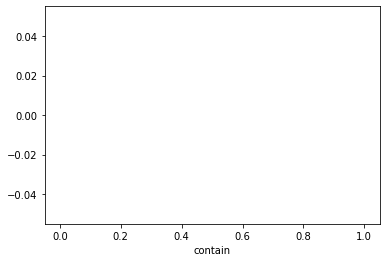

In [ ]:
sns.distplot(a=msg[msg['label']==0].contain,kde=False)

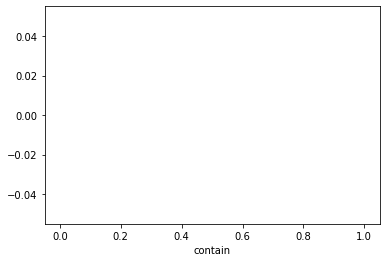

In [ ]:
sns.distplot(a=msg[msg['label']==1].contain,kde=False)

In [ ]:
#data cleaning/preprocessing - removing punctuation and digits 
msg['cleaned_text']=""

for i in msg.index:
  updated_list=[]
  for j in range(len(msg['text'][i])):
    if msg['text'][i][j] not in string.punctuation:
      if msg['text'][i][j].isdigit()==False:
        updated_list.append(msg['text'][i][j])
  updated_string="".join(updated_list)
  msg['cleaned_text'][i]=updated_string

msg.drop(['text'],axis=1,inplace=True)
msg.head() 

,label,length,contain,cleaned_text
0,ham,111,0,Go until jurong point crazy Available only in ...
1,ham,29,0,Ok lar Joking wif u oni
2,spam,155,1,Free entry in a wkly comp to win FA Cup final...
3,ham,49,0,U dun say so early hor U c already then say
4,ham,61,0,Nah I dont think he goes to usf he lives aroun...


In [ ]:
#data cleaning/preprocessing - tokenization and convert to lower case 
msg['token']=""

for i in msg.index:
  msg['token'][i]=re.split("\W+",msg['cleaned_text'][i].lower())

msg.head()

,label,length,contain,cleaned_text,token
0,ham,111,0,Go until jurong point crazy Available only in ...,"[go, until, jurong, point, crazy, available, o..."
1,ham,29,0,Ok lar Joking wif u oni,"[ok, lar, joking, wif, u, oni]"
2,spam,155,1,Free entry in a wkly comp to win FA Cup final...,"[free, entry, in, a, wkly, comp, to, win, fa, ..."
3,ham,49,0,U dun say so early hor U c already then say,"[u, dun, say, so, early, hor, u, c, already, t..."
4,ham,61,0,Nah I dont think he goes to usf he lives aroun...,"[nah, i, dont, think, he, goes, to, usf, he, l..."


In [ ]:
#data cleaning/preprocessing - stopwords
msg['updated_token']=""
stopwords=nltk.corpus.stopwords.words('english')

for i in msg.index:
  updated_list=[]
  for j in range(len(msg['token'][i])):
    if msg['token'][i][j] not in stopwords:
      updated_list.append(msg['token'][i][j])
  msg['updated_token'][i]=updated_list

msg.drop(['token'],axis=1,inplace=True)
msg.head()

,label,length,contain,cleaned_text,updated_token
0,0,111,0,Go until jurong point crazy Available only in ...,"[go, jurong, point, crazy, available, bugis, n..."
1,0,29,0,Ok lar Joking wif u oni,"[ok, lar, joking, wif, u, oni]"
2,1,155,1,Free entry in a wkly comp to win FA Cup final...,"[free, entry, wkly, comp, win, fa, cup, final,..."
3,0,49,0,U dun say so early hor U c already then say,"[u, dun, say, early, hor, u, c, already, say]"
4,0,61,0,Nah I dont think he goes to usf he lives aroun...,"[nah, dont, think, goes, usf, lives, around, t..."


In [ ]:
#data cleaning/preprocessing - lemmatization 
msg['lem_text']=""
wordlem=nltk.WordNetLemmatizer()

for i in msg.index:
  updated_list=[]
  for j in range(len(msg['updated_token'][i])):
    updated_list.append(wordlem.lemmatize(msg['updated_token'][i][j]))
  msg['lem_text'][i]=updated_list 

msg.drop(['updated_token'],axis=1,inplace=True)
msg.head()

,label,length,contain,cleaned_text,lem_text
0,0,111,0,Go until jurong point crazy Available only in ...,"[go, jurong, point, crazy, available, bugis, n..."
1,0,29,0,Ok lar Joking wif u oni,"[ok, lar, joking, wif, u, oni]"
2,1,155,1,Free entry in a wkly comp to win FA Cup final...,"[free, entry, wkly, comp, win, fa, cup, final,..."
3,0,49,0,U dun say so early hor U c already then say,"[u, dun, say, early, hor, u, c, already, say]"
4,0,61,0,Nah I dont think he goes to usf he lives aroun...,"[nah, dont, think, go, usf, life, around, though]"


In [ ]:
#data cleaning/preprocessing - merging token
msg['final_text']=""

for i in msg.index:
  updated_string=" ".join(msg['lem_text'][i])
  msg['final_text'][i]=updated_string

msg.drop(['cleaned_text','lem_text'],axis=1,inplace=True)
msg.head()

,label,length,contain,final_text
0,0,111,0,go jurong point crazy available bugis n great ...
1,0,29,0,ok lar joking wif u oni
2,1,155,1,free entry wkly comp win fa cup final tkts st ...
3,0,49,0,u dun say early hor u c already say
4,0,61,0,nah dont think go usf life around though


In [ ]:
#separating target and features
y=pd.DataFrame(msg.label)
x=msg.drop(['label'],axis=1)
#splitting the data (80:20 ratio)
x_train,x_val,y_train,y_val=train_test_split(x,y,train_size=0.8,test_size=0.2,random_state=0)

In [ ]:
#count vectorization 
cv=CountVectorizer(max_features=5000)
temp_train=cv.fit_transform(x_train['final_text']).toarray()
temp_val=cv.transform(x_val['final_text']).toarray()

In [ ]:
#tfidf
tf=TfidfTransformer()
temp_train=tf.fit_transform(temp_train)
temp_val=tf.transform(temp_val)
#merging temp datafram with original dataframe
temp_train=pd.DataFrame(temp_train.toarray(),index=x_train.index)
temp_val=pd.DataFrame(temp_val.toarray(),index=x_val.index)
x_train=pd.concat([x_train,temp_train],axis=1,sort=False)
x_val=pd.concat([x_val,temp_val],axis=1,sort=False)

x_train.head()

,length,contain,final_text,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,...,4960,4961,4962,4963,4964,4965,4966,4967,4968,4969,4970,4971,4972,4973,4974,4975,4976,4977,4978,4979,4980,4981,4982,4983,4984,4985,4986,4987,4988,4989,4990,4991,4992,4993,4994,4995,4996,4997,4998,4999
3794,45,0,also remember bead dont come ever,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4290,25,0,call ure done,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2603,99,0,im arestaurant eating squid wanna dosomething ...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3452,274,0,nowadays people notixiquating laxinorficated o...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3132,25,0,message food,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
#dropping the final_text column
x_train.drop(['final_text'],axis=1,inplace=True)
x_val.drop(['final_text'],axis=1,inplace=True)

x_train.head()

,length,contain,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,...,4960,4961,4962,4963,4964,4965,4966,4967,4968,4969,4970,4971,4972,4973,4974,4975,4976,4977,4978,4979,4980,4981,4982,4983,4984,4985,4986,4987,4988,4989,4990,4991,4992,4993,4994,4995,4996,4997,4998,4999
3794,45,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4290,25,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2603,99,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3452,274,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3132,25,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
#converting the labels to int datatype (for model training)
y_train=y_train.astype(int)
y_val=y_val.astype(int)

BELOW ARE THE THREE TYPES OF CLASSIFICATION TO CHECK THE CONFUSION MATRIX,ACCURACY,PRECISION,RECALL,F1-SCORE AND SYSTEM FOR OUR SPAM MODEL.

MULTINOMIAL NAIVE BAYES:

In [ ]:
#Multinomial Naive Bayes
model=MultinomialNB()
model.fit(x_train,y_train)
ypreds=model.predict(x_val)
print("Multinomial Naive Bayes:",accuracy_score(y_val,ypreds))

Multinomial Naive Bayes: 0.9245647969052224


CONFUSION MATRIX

TRUE NEGATIVE:
 884
FALSE POSITIVE:
 1
FALSE NEGATIVE:
 77
TRUE POSITIVE:
 72


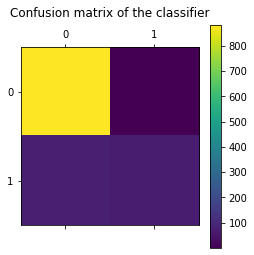

ACCURACY OF THE MODEL IS: 0.9245647969052224


In [ ]:
from sklearn.metrics import confusion_matrix
import pylab as pl
cm1= confusion_matrix(y_val, ypreds)
TN, FP, FN, TP =  confusion_matrix = cm1[0][0], cm1[0][1], cm1[1][0],cm1[1][1]
print("TRUE NEGATIVE:\n",TN)
print("FALSE POSITIVE:\n",FP)
print("FALSE NEGATIVE:\n",FN)
print("TRUE POSITIVE:\n",TP)
pl.matshow(cm1)
pl.title('Confusion matrix of the classifier\n')
pl.colorbar()
pl.show()
accuracy=(TP+TN)/(TP+TN+FP+FN)
print("ACCURACY OF THE MODEL IS:",accuracy)

PRECISION VALUE,RECALL AND F1-SCORE OF A MODEL

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_val,ypreds))

              precision    recall  f1-score   support

           0       0.92      1.00      0.96       885
           1       0.99      0.48      0.65       149

    accuracy                           0.92      1034
   macro avg       0.95      0.74      0.80      1034
weighted avg       0.93      0.92      0.91      1034



RANDOM FOREST:

In [ ]:
model=RandomForestClassifier(n_estimators=100,random_state=0)
model.fit(x_train,y_train)
y_preds=model.predict(x_val)
print("Random Forest:",accuracy_score(y_val,y_preds))

Random Forest: 0.9816247582205029


CONFUSION MATRIX

TRUE NEGATIVE:
 884
FALSE POSITIVE:
 1
FALSE NEGATIVE:
 18
TRUE POSITIVE:
 131


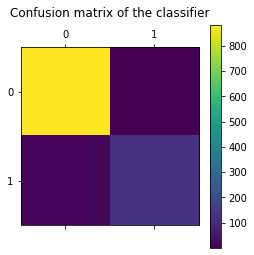

ACCURACY OF THE MODEL IS: 0.9816247582205029


In [ ]:
from sklearn.metrics import confusion_matrix
import pylab as pl
cm2= confusion_matrix(y_val, y_preds)
TN, FP, FN, TP =  confusion_matrix = cm2[0][0], cm2[0][1], cm2[1][0],cm2[1][1]
print("TRUE NEGATIVE:\n",TN)
print("FALSE POSITIVE:\n",FP)
print("FALSE NEGATIVE:\n",FN)
print("TRUE POSITIVE:\n",TP)
pl.matshow(cm2)
pl.title('Confusion matrix of the classifier\n')
pl.colorbar()
pl.show()
accuracy=(TP+TN)/(TP+TN+FP+FN)
print("ACCURACY OF THE MODEL IS:",accuracy)

PRECISION VALUE,RECALL AND F1-SCORE OF A MODEL

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_val,y_preds))

              precision    recall  f1-score   support

           0       0.98      1.00      0.99       885
           1       0.99      0.88      0.93       149

    accuracy                           0.98      1034
   macro avg       0.99      0.94      0.96      1034
weighted avg       0.98      0.98      0.98      1034



LOGISTIC REGRESSION:

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
Spam_model = LogisticRegression(solver='liblinear', penalty='l1')
Spam_model.fit(x_train,y_train)
pred = Spam_model.predict(x_val)
accuracy_score(y_val,pred)


0.9758220502901354

CONFUSION MATRIX

TRUE NEGATIVE:
 877
FALSE POSITIVE:
 8
FALSE NEGATIVE:
 17
TRUE POSITIVE:
 132


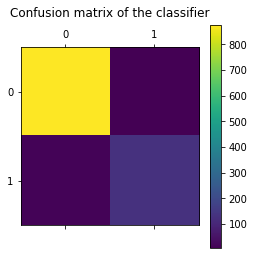

ACCURACY OF THE MODEL IS: 0.9758220502901354


In [ ]:
from sklearn.metrics import confusion_matrix
import pylab as pl
cm= confusion_matrix(y_val, pred)
TN, FP, FN, TP =  confusion_matrix = cm[0][0], cm[0][1], cm[1][0],cm[1][1]
print("TRUE NEGATIVE:\n",TN)
print("FALSE POSITIVE:\n",FP)
print("FALSE NEGATIVE:\n",FN)
print("TRUE POSITIVE:\n",TP)
pl.matshow(cm)
pl.title('Confusion matrix of the classifier\n')
pl.colorbar()
pl.show()
accuracy=(TP+TN)/(TP+TN+FP+FN)
print("ACCURACY OF THE MODEL IS:",accuracy)

PRECISION VALUE,RECALL AND F1-SCORE OF A MODEL

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_val,pred))

              precision    recall  f1-score   support

           0       0.98      0.99      0.99       885
           1       0.94      0.89      0.91       149

    accuracy                           0.98      1034
   macro avg       0.96      0.94      0.95      1034
weighted avg       0.98      0.98      0.98      1034

